# Zadanie z predmetu IAU - Inteligentna analyza udajov  
# 1. etapa - analyza udajov   
### Autori: Michal Kabac, Tadeas Drahovsky  
Percentualny podiel 50%, 50%

In [58]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import datetime
from datetime import datetime,date
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import json
import re
import dateutil.parser as parser
import statsmodels.api as sm

## Nacitanie dat  
Na zaciatku je potrebne si datatsety nacitat. Datasety si nacitame pomocou kniznice pandas a prikazu read_csv. Pre analyzu nam postaci testovaci dataset. Preto si nacitame iba ten.

In [17]:
other_data_train = pd.read_csv("33/other_train.csv")
personal_data_train = pd.read_csv("33/personal_train.csv")

# Analyza dat

Teraz sa pozrieme ako nas dataset vyzera. Postaci nam na to zopar riadkov. Preto pouzijeme prikaz head.

In [18]:
other_data_train.head()

,Unnamed: 0,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,...,fnlwgt,class,income,medical_info,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass
0,0,Marco Stanton,"958 Smith Pike Suite 249\r\nLake Andrewton, GA...",9.246478,Exec-managerial,Married-civ-spouse,f,13.0,Husband,14.682571,...,118853.0,0.0,<=50K,"{'mean_glucose':'79.8359375','std_glucose':'38...",United-States,0.0,2.118729,60.0,White,Private
1,1,Benjamin Holman,Unit 1778 Box 6724\r\nDPO AE 34370,22.091694,Adm-clerical,Never-married,f,10.0,Other-relative,8.827777,...,318822.0,0.0,<=50K,"{'mean_glucose':'117.46875','std_glucose':'52....",United-States,0.0,0.671405,40.0,White,Private
2,2,Robert Sullivan,"76441 Erin Trail\r\nWest Jared, WI 77001",5.677978,Exec-managerial,Never-married,f,13.0,Not-in-family,31.281121,...,178815.0,0.0,>50K,"{'mean_glucose':'109.0234375','std_glucose':'4...",United-States,0.0,5.670569,40.0,White,Private
3,3,John Franck,"623 Desiree Run\r\nJosephville, MI 23247",0.214241,Sales,Never-married,f,8.0,Not-in-family,65.506380,...,213002.0,1.0,<=50K,"{'mean_glucose':'16.0546875','std_glucose':'-3...",United-States,0.0,125.755853,50.0,White,Private
4,4,David Lackland,"8323 Moss Station\r\nJuliefurt, AZ 43882",8.791325,Machine-op-inspct,Never-married,f,6.0,Own-child,18.180651,...,217404.0,0.0,<=50K,"{'mean_glucose':'110.1796875','std_glucose':'5...",United-States,0.0,2.556856,40.0,White,self-emp-not-inc


V tomto datasete vidime ze prvy stlpec je Unnamed: co su v podstate indexy zaznamov, takze tento stlpec bude treba nastavit ako index. Dalsi stlpec je meno pacienta. Potom nasleduje adresa pacienta. S adresou sa asi moc neoplati pracovat, nakolko adresa pri predikovani cukrovky nie je podstatna. Potom nasleduju nejake hodnoty kyslika, atd. Ostatne informacie su nejake merania lekarov alebo sukromne zaznami. Zaujimavy je ale stlpec medical_info, ktory vyzera ze je v jason formate a bude ho treba rozdelit na viacero stlpcov

In [19]:
other_data_train.shape[0]

3983

Prikazom vyssie som chcel zistit pocet riadkov v datasete. Takto vieme ze mame 3983 riadkovy dataset

In [20]:
other_data_train.shape[1]

23

Pocet stlpcov tohoto datasetu je 23.  
Podme sa pozriet na nejake deskriptivne statistiky

In [21]:
other_data_train.describe()

,Unnamed: 0,kurtosis_oxygen,education-num,std_oxygen,capital-gain,skewness_oxygen,fnlwgt,class,capital-loss,mean_oxygen,hours-per-week
count,3983.00000,3972.000000,3963.000000,3970.000000,3968.000000,3972.000000,3968.000000,3969.000000,3970.000000,3962.000000,3963.000000
mean,1991.00000,7.404816,10.141055,31.181140,1041.573841,91.315105,186040.086442,0.257999,86.775315,18.460443,40.060056
std,1149.93739,4.811752,2.550952,22.292170,7444.237341,108.534576,104070.184399,0.437589,398.685551,34.752774,12.493226
min,0.00000,-2.597872,1.000000,7.370432,0.000000,-1.976976,14878.000000,0.000000,0.000000,0.213211,1.000000
25%,995.50000,3.621181,9.000000,15.040901,0.000000,12.666769,114504.750000,0.000000,0.000000,2.065217,39.000000
50%,1991.00000,7.783017,10.000000,20.557682,0.000000,68.623477,175647.500000,0.000000,0.000000,3.234532,40.000000
75%,2986.50000,10.263412,13.000000,43.369641,0.000000,127.017151,235296.000000,1.000000,0.000000,12.643813,45.000000
max,3982.00000,34.539844,16.000000,110.642211,99999.000000,1191.000837,889965.000000,1.000000,2824.000000,217.371238,99.000000


Z tejto tabulky vidime zakladne descriptivne udaje ako su pocet zaznamov, priemer, minimum, maximum, prvy kvartil, median, 3. kvartil a maximum. Tato tabulka sa mi zobrazila pre vsetky atributy, ktore maju numericke hodnoty

In [22]:
other_data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 23 columns):
Unnamed: 0         3983 non-null int64
name               3983 non-null object
address            3983 non-null object
kurtosis_oxygen    3972 non-null float64
occupation         3967 non-null object
marital-status     3973 non-null object
pregnant           3973 non-null object
education-num      3963 non-null float64
relationship       3967 non-null object
std_oxygen         3970 non-null float64
capital-gain       3968 non-null float64
skewness_oxygen    3972 non-null float64
education          3970 non-null object
fnlwgt             3968 non-null float64
class              3969 non-null float64
income             3968 non-null object
medical_info       3970 non-null object
native-country     3971 non-null object
capital-loss       3970 non-null float64
mean_oxygen        3962 non-null float64
hours-per-week     3963 non-null float64
race               3970 non-null object
work

Vyssie zadany prikaz info som zadal preto, aby som videl akeho typu jednotlive atributy su. Niektore atributy, ktore nie su numericke, bude treba na ne zaviest pre lepsie trenovanie algotimu. Ide napr o atributy ako relationship, pregmant,income.Nominalne atributy, ktore by sa oplatilo zakodovat su napr. native-country, workclass, race, ocupation

Podme sa skusit pozriet ci mame nejake hodnoty nulove

In [23]:
other_data_train.isnull().sum()

Unnamed: 0          0
name                0
address             0
kurtosis_oxygen    11
occupation         16
marital-status     10
pregnant           10
education-num      20
relationship       16
std_oxygen         13
capital-gain       15
skewness_oxygen    11
education          13
fnlwgt             15
class              14
income             15
medical_info       13
native-country     12
capital-loss       13
mean_oxygen        21
hours-per-week     20
race               13
workclass          13
dtype: int64

Z tabulky vyssie vidime ze mame vela hodnot, ktore su nulove. Tieto hodnoty bude treba doplnit. Na doplnenie hodnot pri predspracovani uvazujeme nad viacerymi metodami. Napr. doplnenie medianu, doplnenie priemeru, a planujeme pouzit aj nejake zlozitejsie strategie ako napr. K-means, alebo linearnu regresiu.

Skontrolujme, ci nemame nejake duplicitne zaznami

In [24]:
other_data_train[other_data_train.duplicated()]

,Unnamed: 0,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,...,fnlwgt,class,income,medical_info,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass


Z tohoto prikazu vieme, ze v datasete sa ziadne duplicitne riadky nenachadzaju. Skusme sa ale pozriet napr. na duplicity v menach, co by mohlo mat problem pri spajani datasetu

In [35]:
data_frame[data_frame.name.isin(data_frame.name[data_frame.name.duplicated()])].sort_values(by=['name'])

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
index,,,,,,,,,,,,,,,,,,,,,
1885,Albert Menefee,"992 Hanson Shore\r\nJamesmouth, OR 19553",8.307373,Adm-clerical,NaN,f,NaN,Not-in-family,20.185017,0.0,...,NaN,0.0,2.943144,40.0,White,private,NaN,NaN,NaN,NaN
1970,Albert Menefee,"992 Hanson Shore\r\nJamesmouth, OR 19553",8.307373,Adm-clerical,Never-married,f,9.0,Not-in-family,20.185017,NaN,...,United-States,0.0,2.943144,40.0,White,private,119.835938,51.039013,0.035287,0.052893
3780,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",1.480079,Sales,Married-civ-spouse,f,NaN,Husband,63.083055,0.0,...,United-States,0.0,47.209866,50.0,White,Private,26.937500,32.131991,4.928412,27.057056
2744,Alex Stubblefield,"PSC 1476, Box 5156\r\nAPO AE 20184",NaN,Sales,Married-civ-spouse,NaN,10.0,NaN,63.083055,0.0,...,United-States,0.0,47.209866,NaN,White,Private,26.937500,32.131991,4.928412,27.057056
77,Alfred Booth,"PSC 4136, Box 3084\r\nAPO AA 67974",NaN,Prof_specialty,NaN,f,14.0,Not-in-family,9.285241,0.0,...,United-States,0.0,0.612040,45.0,NaN,Private,121.390625,49.963774,0.131397,-0.218170
1529,Alfred Booth,"PSC 4136, Box 3084\r\nAPO AA 67974",21.198564,Prof_specialty,Never-married,f,NaN,NaN,9.285241,0.0,...,United-States,0.0,0.612040,45.0,White,Private,121.390625,49.963774,0.131397,-0.218170
3366,Alonzo Ellis,7401 Donaldson Lake Apt. 338\r\nPort Wayneview...,-0.648924,Farming-fishing,Married-civ-spouse,f,NaN,Husband,93.781103,7298.0,...,United-States,0.0,NaN,NaN,White,Self-emp-not-inc,85.562500,62.431807,0.934046,0.007399
1953,Alonzo Ellis,7401 Donaldson Lake Apt. 338\r\nPort Wayneview...,-0.648924,Farming-fishing,Married-civ-spouse,f,10.0,Husband,93.781103,7298.0,...,NaN,0.0,156.728261,60.0,White,Self-emp-not-inc,85.562500,62.431807,0.934046,0.007399
907,Angel Johnson,USNS Henderson\r\nFPO AE 50051,NaN,Farming-fishing,Married-civ-spouse,f,9.0,Husband,35.958174,0.0,...,Vietnam,2457.0,9.294314,40.0,Asian-Pac-Islander,Self-emp-not-inc,53.968750,31.900220,3.149333,16.019670


Takze v mene sme nasli duplicitne zaznami. Nas navrh na odstranenie je taky, ze si pozrieme meno a adresu, pripadne datum narodenia a zistime ci sa jedna o rovnaku osobu alebo menovca. Vo vypise je vidiet ze niektore hodnoty su nevyplnene. Takze doplnime chybajuce hodnoty a druhy zaznam vymazeme.

Aby sme mohli data dalej analyzovat, rozdelime si stlpec medical_info do viacerych stlpcov. Zrobime to tak, ze dataset si nacitame vo formate json. Na zaciatku sa pozrieme na prvy riadok a zistime ake nazvy sa tam nachadzaju. Tieto nazvy si ulozime. To budu nove nazvi stlpcov. Nasledne cyklom prejdeme a ulozime si vsetky hodnoty.

In [26]:
data_frame = {}
med_inf = other_data_train.medical_info
med_inf = med_inf.str.replace("'", '"').tolist()
data_keys = json.loads(med_inf[0]).keys()

for data_key in data_keys:
    data_frame[data_key] = []

for data in med_inf:
    if isinstance(data, str):
        values = json.loads(data)
        for data_key in data_keys:
            data_frame[data_key].append(values[data_key])
    else:
        for data_key in data_keys:
            data_frame[data_key].append(np.NaN)

Teraz si nasledujuce data vypiseme

In [28]:
data_frame = pd.DataFrame(data_frame)
data_frame.head()

,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
0,79.8359375,38.73200738,0.835316999,2.014008974
1,117.46875,52.07505663,-0.041947703,-0.474659038
2,109.0234375,49.13493297,0.322659154,0.131936945
3,16.0546875,-3806.004889,4.992567838,25.49145159
4,110.1796875,50.86462327,0.4802492820000001,-0.024075919


Podla vsetkeho budu tieto data reprezentovane ako stringy. Podme to skusit zistit prikazom info

In [29]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 4 columns):
mean_glucose        3970 non-null object
std_glucose         3970 non-null object
kurtosis_glucose    3970 non-null object
skewness_glucose    3970 non-null object
dtypes: object(4)
memory usage: 124.5+ KB


Ak sa chceme dalej pozerat na tieto data a vizualizovat ich, potrebujeme ich mat numericke a nie ako stringy, data zmenime na numericke prikazom .astype(float)

In [30]:
data_frame.mean_glucose = data_frame.mean_glucose.astype(float)
data_frame.std_glucose = data_frame.std_glucose.astype(float)
data_frame.kurtosis_glucose = data_frame.kurtosis_glucose.astype(float)
data_frame.skewness_glucose = data_frame.skewness_glucose.astype(float)
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3983 entries, 0 to 3982
Data columns (total 4 columns):
mean_glucose        3574 non-null float64
std_glucose         3970 non-null float64
kurtosis_glucose    3970 non-null float64
skewness_glucose    3970 non-null float64
dtypes: float64(4)
memory usage: 124.5 KB


Hodnoty uz su zmenene na numericke. Zaroven vidime ze v stlcpi mean_glucose bude treba dopocitat nejake hodnoty. Takisto chyba 13 hodnot aj v ostatnych stlpcoch. Podme sa pozriet na nejake deskriptivne statistiky. 

In [31]:
data_frame.describe()

,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
count,3574.000000,3970.000000,3970.000000,3970.000000
mean,101.411538,42.443124,0.955236,4.242163
std,33.594389,1453.555015,1.614509,9.704929
min,6.187500,-6892.691548,-1.641515,-1.755332
25%,87.812500,39.248643,0.072820,-0.119070
50%,110.839844,45.859117,0.311953,0.374657
75%,124.291016,50.979629,0.789155,2.092365
max,189.734375,6099.616917,8.069522,68.101622


Z deskriptivnej statistiky sa javy, ze by tu mohlo ist o nejakych outlyerov, napr. v stlpci skewness_glucose je hodnota 3. kvartilu 2.09 a maximum je 68.10. Takisto sa mozu outlyeri nachadzat v stlpci std_glucose lebo hodnota maxima je dost vysoka oproti hodnote 3. kvartilu, minimum v tomto stlpci sa mi tiez nepozdava. Tieto hodnoty bude treba normalizovat, alebo pouzit niektoru zo strategii na nahradenie hodnoty(napr. nahradenie medianom nakolko priemer je dost nachylny na outlyerov a v priemere je zapocitany aj outlyer)

Pozrime sa ako vyzeraju data, kde chybaju nejake hodnoty

In [32]:
data_frame[data_frame.kurtosis_glucose.isnull()]

,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
241,NaN,NaN,NaN,NaN
446,NaN,NaN,NaN,NaN
585,NaN,NaN,NaN,NaN
925,NaN,NaN,NaN,NaN
1761,NaN,NaN,NaN,NaN
1820,NaN,NaN,NaN,NaN
1885,NaN,NaN,NaN,NaN
1927,NaN,NaN,NaN,NaN
1998,NaN,NaN,NaN,NaN
2527,NaN,NaN,NaN,NaN


Tie zaznami, kde nieco chyba nemaju vyplnenu ziadnu hodnotu. Bud bude treba danu hodnotu dopocitat z ostatnych atributov, nahradit medianom, alebo v najhorsom pripade dany riadok dropnut

Teraz by pasovalo nasledujuce datasety spojit. Pouzijeme na to prikaz concat z kniznice pandas. Spojime to podla indexov, nakolko zaznami su tahane z rovnakeho riadka, a teda indexy sa nam rovnaju

In [33]:
data_frame = pd.concat([other_data_train, data_frame.reindex(other_data_train.index)], axis=1)
data_frame

,Unnamed: 0,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
0,0,Marco Stanton,"958 Smith Pike Suite 249\r\nLake Andrewton, GA...",9.246478,Exec-managerial,Married-civ-spouse,f,13.0,Husband,14.682571,...,United-States,0.0,2.118729,60.0,White,Private,79.835938,38.732007,0.835317,2.014009
1,1,Benjamin Holman,Unit 1778 Box 6724\r\nDPO AE 34370,22.091694,Adm-clerical,Never-married,f,10.0,Other-relative,8.827777,...,United-States,0.0,0.671405,40.0,White,Private,117.468750,52.075057,-0.041948,-0.474659
2,2,Robert Sullivan,"76441 Erin Trail\r\nWest Jared, WI 77001",5.677978,Exec-managerial,Never-married,f,13.0,Not-in-family,31.281121,...,United-States,0.0,5.670569,40.0,White,Private,109.023438,49.134933,0.322659,0.131937
3,3,John Franck,"623 Desiree Run\r\nJosephville, MI 23247",0.214241,Sales,Never-married,f,8.0,Not-in-family,65.506380,...,United-States,0.0,125.755853,50.0,White,Private,16.054688,-3806.004889,4.992568,25.491452
4,4,David Lackland,"8323 Moss Station\r\nJuliefurt, AZ 43882",8.791325,Machine-op-inspct,Never-married,f,6.0,Own-child,18.180651,...,United-States,0.0,2.556856,40.0,White,self-emp-not-inc,110.179688,50.864623,0.480249,-0.024076
5,5,George Esperanza,"768 Lori Port\r\nBenjaminfurt, LA 20386",10.811388,Exec-managerial,Married-civ-spouse,f,12.0,Husband,13.245584,...,United-States,0.0,2.082776,6.0,Asian-Pac-Islander,Private,121.734375,44.908150,0.411469,0.511960
6,6,Johnny Reynolds,"326 Jose Junction\r\nPort Nicholas, MN 93755",17.160408,Craft_repair,Divorced,F,9.0,Own-child,11.045541,...,United-States,0.0,0.749164,40.0,White,Private,NaN,45.482214,0.589170,0.752646
7,7,Andrew Bryson,"091 Melissa Mount Apt. 387\r\nSamuelfurt, UT 9...",5.934140,Craft-repair,Married-civ-spouse,f,10.0,Husband,33.163527,...,United-States,0.0,5.913880,40.0,Amer-Indian-Eskimo,Private,100.609375,49.557926,0.410835,-0.022671
8,8,John Renk,Unit 5533 Box 2757\r\nDPO AE 13245,3.295862,Prof-specialty,Married-civ-spouse,f,13.0,Wife,41.980672,...,United-States,0.0,14.198997,40.0,White,Private,41.882812,3085.186914,4.354407,24.085368
9,9,Eric Marquez,USS Golden\r\nFPO AP 12414,11.100580,Exec_managerial,Married-civ-spouse,f,9.0,Wife,16.428085,...,United-States,0.0,1.616221,28.0,White,Private,112.734375,48.670526,0.382386,0.038529


Teraz nastavime index na stlpec unnamed 0 a premenujeme ho na index. Iba to kazi tabulku a pri trenovani by nam to nepomohlo. Algoritmus by do trenovania zobral aj tieto indexi.

In [34]:
data_frame = data_frame.rename(columns={'Unnamed: 0': 'index',})
data_frame = data_frame.set_index('index')
data_frame.head()

,name,address,kurtosis_oxygen,occupation,marital-status,pregnant,education-num,relationship,std_oxygen,capital-gain,...,native-country,capital-loss,mean_oxygen,hours-per-week,race,workclass,mean_glucose,std_glucose,kurtosis_glucose,skewness_glucose
index,,,,,,,,,,,,,,,,,,,,,
0,Marco Stanton,"958 Smith Pike Suite 249\r\nLake Andrewton, GA...",9.246478,Exec-managerial,Married-civ-spouse,f,13.0,Husband,14.682571,0.0,...,United-States,0.0,2.118729,60.0,White,Private,79.835938,38.732007,0.835317,2.014009
1,Benjamin Holman,Unit 1778 Box 6724\r\nDPO AE 34370,22.091694,Adm-clerical,Never-married,f,10.0,Other-relative,8.827777,0.0,...,United-States,0.0,0.671405,40.0,White,Private,117.468750,52.075057,-0.041948,-0.474659
2,Robert Sullivan,"76441 Erin Trail\r\nWest Jared, WI 77001",5.677978,Exec-managerial,Never-married,f,13.0,Not-in-family,31.281121,8614.0,...,United-States,0.0,5.670569,40.0,White,Private,109.023438,49.134933,0.322659,0.131937
3,John Franck,"623 Desiree Run\r\nJosephville, MI 23247",0.214241,Sales,Never-married,f,8.0,Not-in-family,65.506380,4650.0,...,United-States,0.0,125.755853,50.0,White,Private,16.054688,-3806.004889,4.992568,25.491452
4,David Lackland,"8323 Moss Station\r\nJuliefurt, AZ 43882",8.791325,Machine-op-inspct,Never-married,f,6.0,Own-child,18.180651,0.0,...,United-States,0.0,2.556856,40.0,White,self-emp-not-inc,110.179688,50.864623,0.480249,-0.024076


Teraz to uz vyzera lepsie. Mozme sa posunut na dalsi krok a tim je vizualizacia dat

## Vizualizacia dat

Na zaciatku si vykreslim grafi pomocou funkcie pairplot. Vykreslim si porovnanie kazdeho atributu s kazdym. Sice je to trochu neprehladne ale moze nam to ukazat zaujimave zavislosti ktore si neskor zobrazime podrobnejsie. Aby nam to aj nieco dalo, ofarbime si to podla toho, ci pacient ma alebo nema cukrovku

/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/michalkabac/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


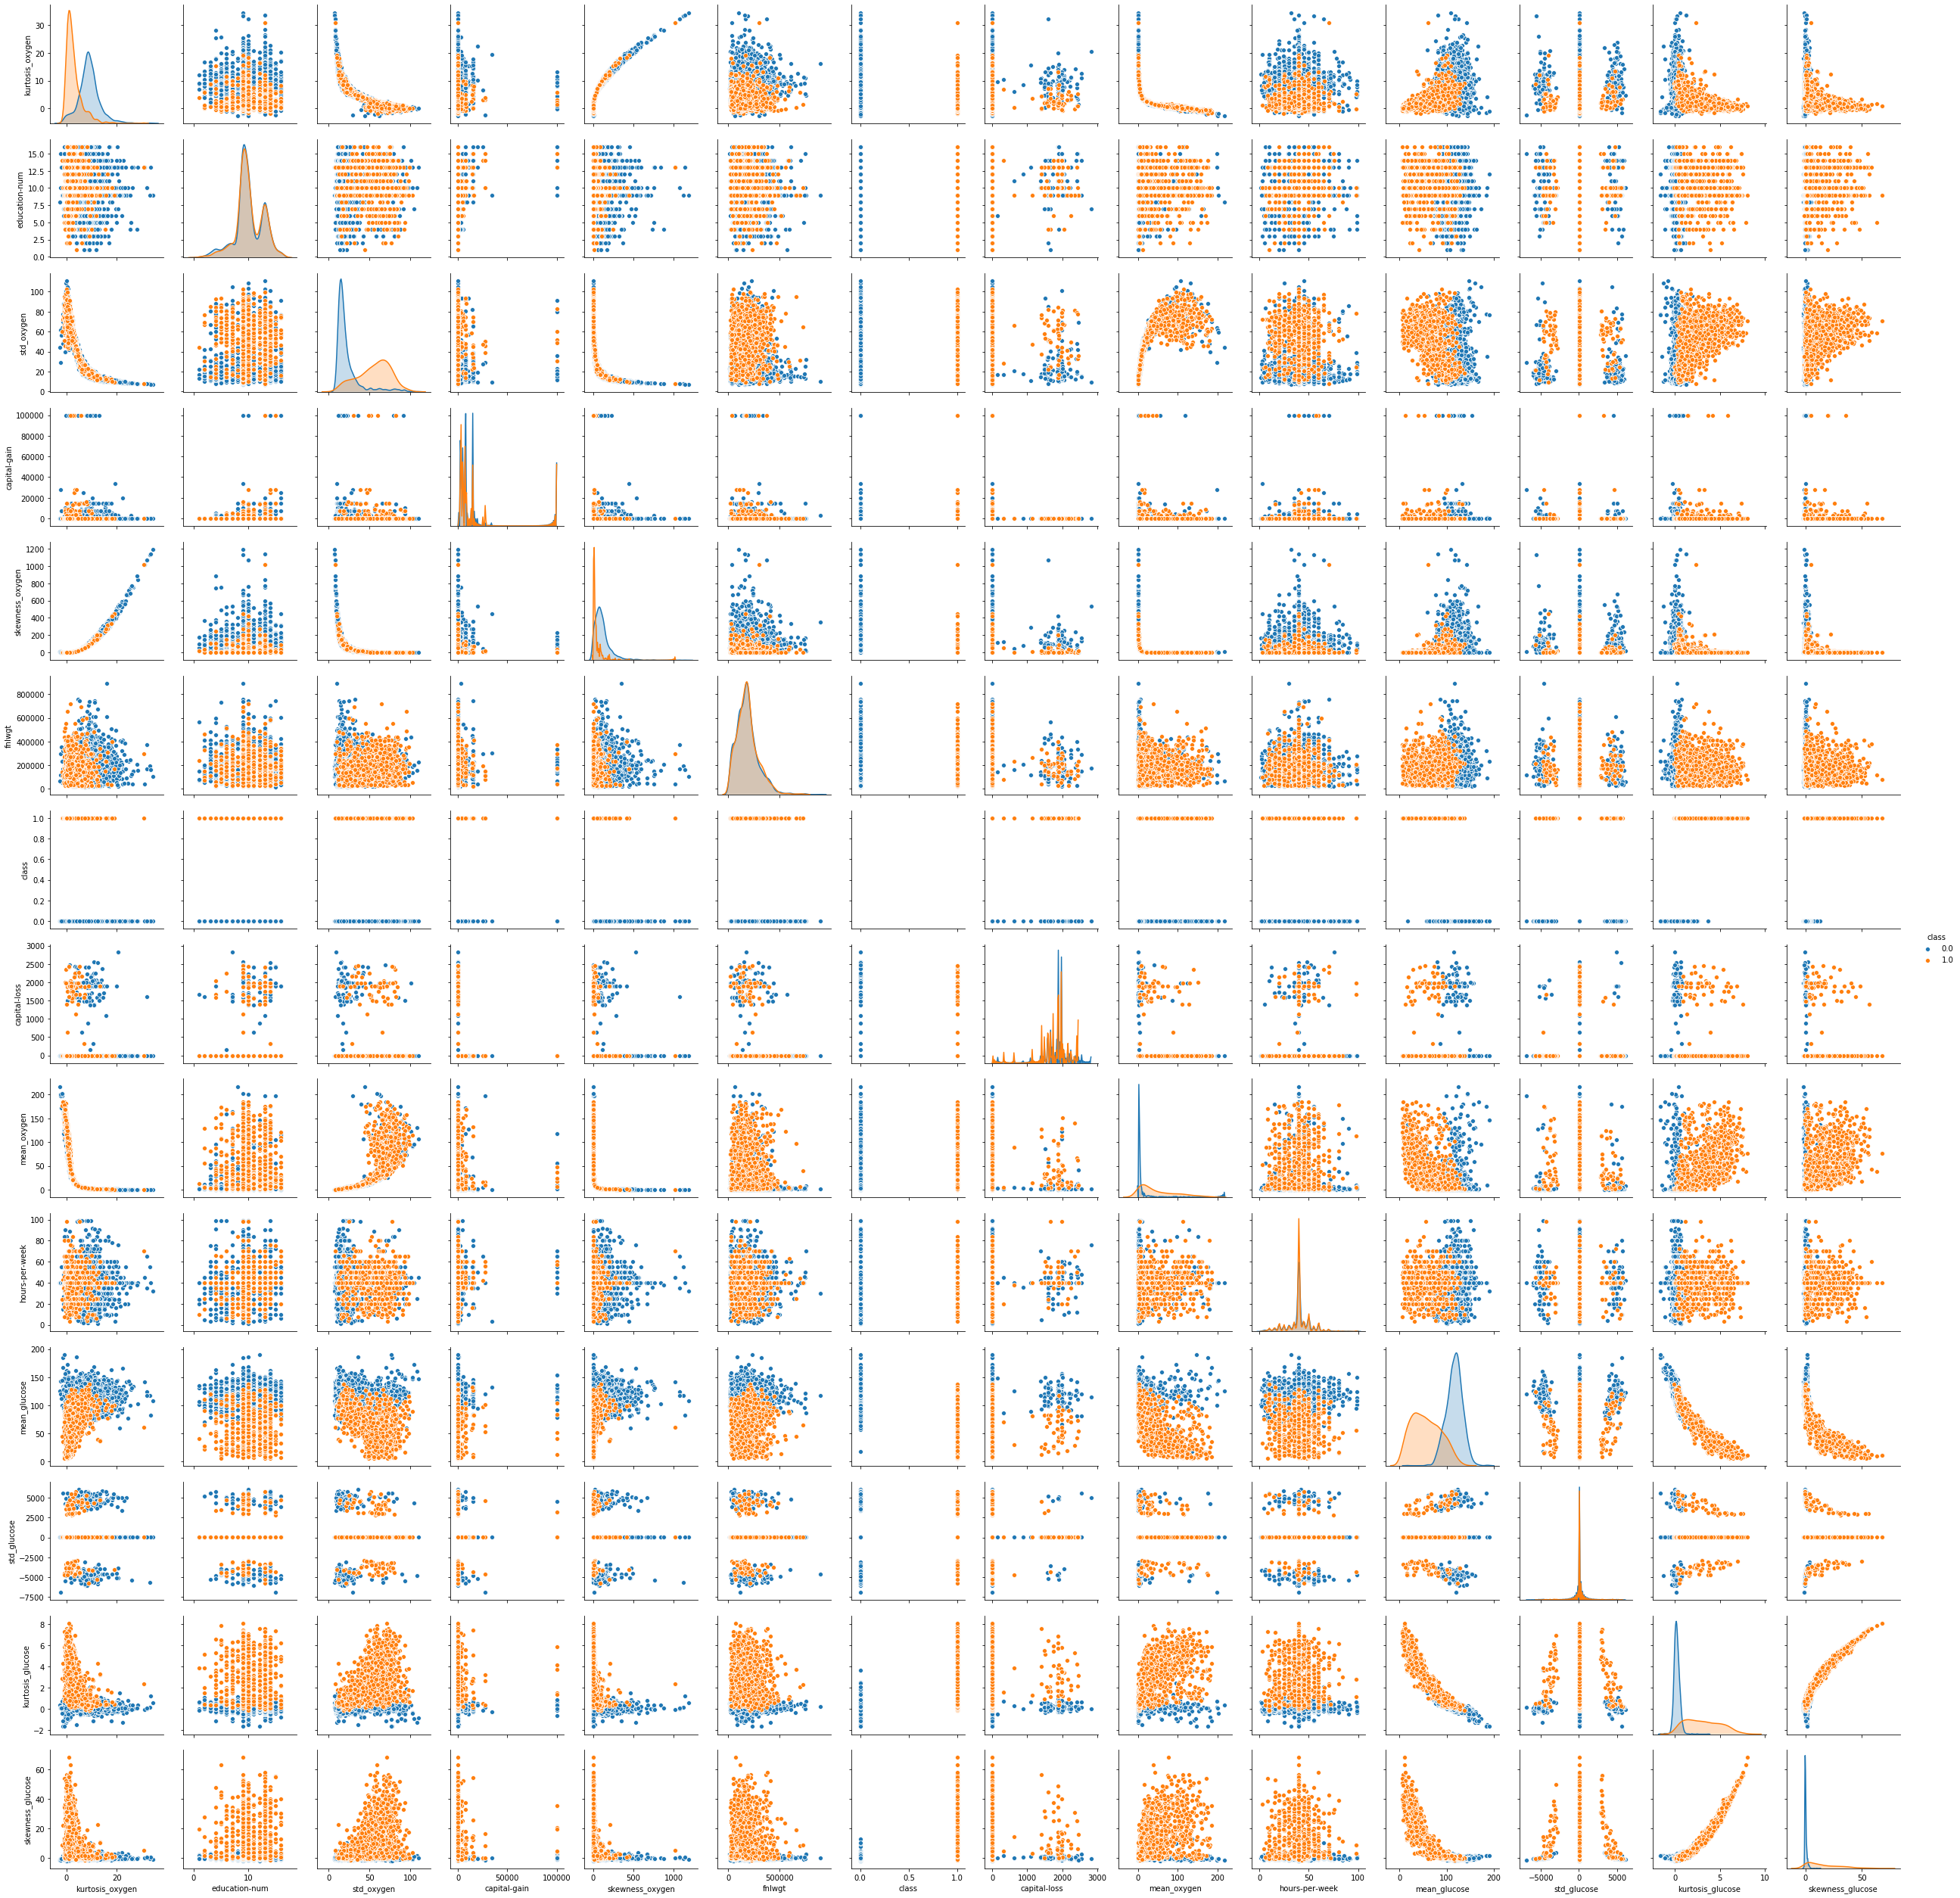

In [94]:
sns.pairplot(data_frame, hue="class")

Tieto data vyzeraju celkom pekne, nakolko sa vo vecsine daju pozorovat 2 zhluky, ktore je mozne rozdelit nejakou funkciou, pripadne ohranicenim. Podme sa na to pozriet blizsie

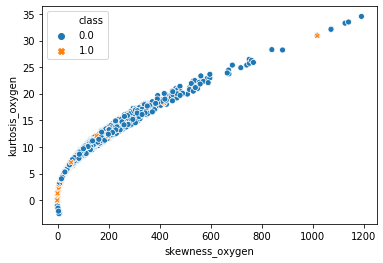

In [96]:
sns.scatterplot(x="skewness_oxygen", y="kurtosis_oxygen",hue="class", style="class", data=data_frame)

Z tohoto grafu je vidno, ze tieto 2 atributy budu na sebe zavisle. Tento graf by sme vedeli prekryt kvadratickou funkciou. Z grafu to vyzera tak, ze ludia s cukrovkou maju hodnotu skewness oxygenu nizsiu oproti zdravemu cloveku. Skusme si tieto 2 atributy vykreslit pomocou boxplotu

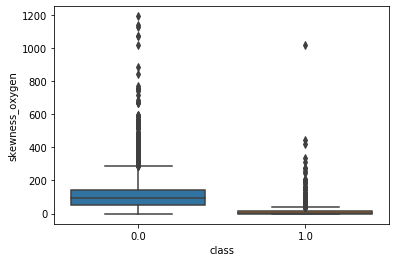

In [25]:
sns.boxplot("class", "skewness_oxygen", data=data_frame)

Z boxplotu je vidiet, ze ludia ktory trpia cukrovkou, maju hladinu skewness oxygenu do 100, vyssiu hodnotu maju ludia, ktori cukrovkou netrpia

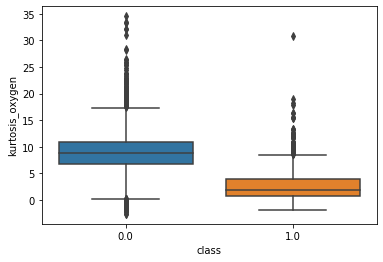

In [26]:
sns.boxplot("class", "kurtosis_oxygen", data=data_frame)

Tak isto ako pri skewness oxygen, boxplot ukazal zavislost medzi kurtosis_oxygen. Ludia trpiaci cukrovkou maju hodnotu kurtosis oxygenu vecsinou do 5, zatial co zdravi ludia maju hodnotu vyssiu

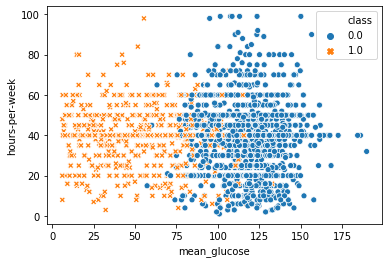

In [19]:
sns.scatterplot(x="mean_glucose", y="hours-per-week",hue="class", style="class", data=data_frame)

Medzi atributmi hours per week a mean glucose vyzera ze je tiez najaky vplyv na cukrovku. Ludia s hodnotou glukozi do 85, maju vecsiu sancu na vyskyt cukrovky. Medzi timito atributmi nevyzera, ze by bola nejaka zavislost

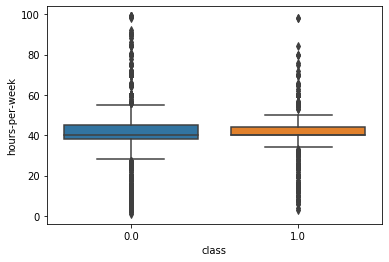

In [27]:
sns.boxplot("class", "hours-per-week", data=data_frame)

Z boxplotu pre pocet odpracovanych hodin tyzdenne nevidno nejaky extra rozdiel v porovnani so zdravymi a chorymi ludmi. Tieto 2 grafy su dost vyrovnane

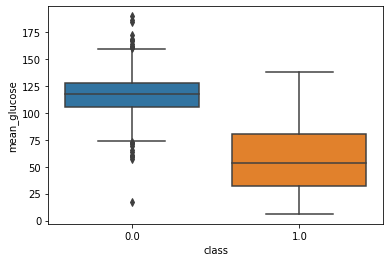

In [28]:
sns.boxplot("class", "mean_glucose", data=data_frame)

Pri boxplote vyssie bolo tazke vyhodnotit nejaky rozdiel, ale na tomto boxplote je pekne vidiet nejaky vztah. Ludia trpiaci cukrovkou maju hodnotu mean glucose vecsinou do 80, zatial co zdravi ludia maju tuto hodnotu v prevaznej miere nad 110

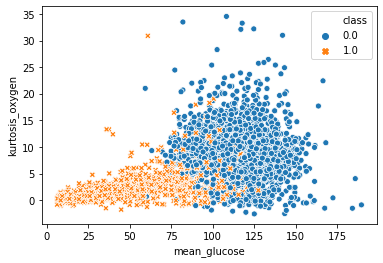

In [29]:
sns.scatterplot(x="mean_glucose", y="kurtosis_oxygen",hue="class", style="class", data=data_frame)

Tento graf vizera taktiez velmi zaujimavo. Z grafu to vizera tak, ze ludia ktory trpia cukrovkou maju vecsinou hodnotu mean glucose do 100 a hodnotu kurtosis oxygenu do 10. Na tomto grafe pekne vidiet 2 zhluky. Vidno tu aj nejaku slabu linearnu zavislost. Boxploty pre tieto atributy uz mame vizualizovane vyssie.

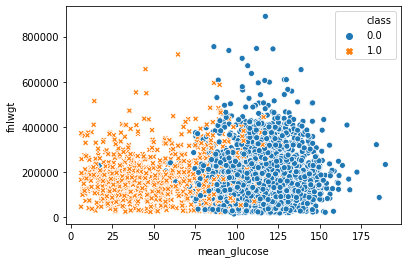

In [30]:
sns.scatterplot(x="mean_glucose", y="fnlwgt",hue="class", style="class", data=data_frame)

Pri tomto grafe je taktiez pekne vidiet 2 zhluky. Ludia s cukrovkou maju vecsinou mean glucose do 85 a fnlwgt do 400 000. Nejaka extra velka zavislost medzi atributmi nevyzera byt.

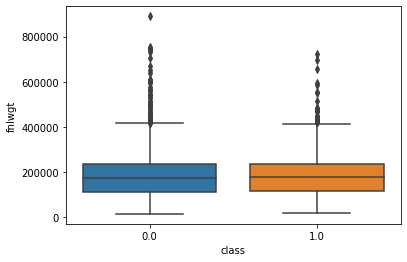

In [31]:
sns.boxplot("class", "fnlwgt", data=data_frame)

fnlwgt ma boxploty taktiez celkom vyvazene. Takze pre tento atribut sa nejaka predpoved neda vyvodit

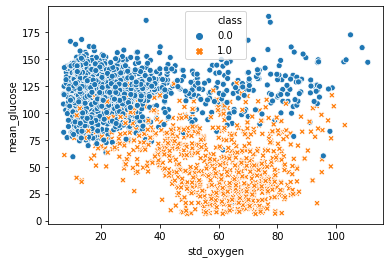

In [33]:
sns.scatterplot(x="std_oxygen", y="mean_glucose",hue="class", style="class", data=data_frame)

Medzi timito 2 atributmi nejaka velka zavislost nevyzera byt. Z grafu je vidno, za data su rozdelene do 2 zhlukov.

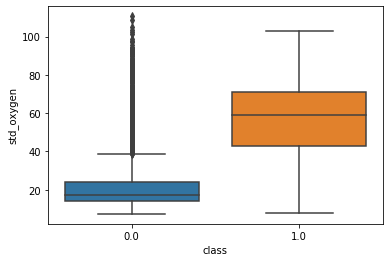

In [34]:
sns.boxplot("class", "std_oxygen", data=data_frame)

Na boxplote je vidiet rozdiel medzi zdravymi a chorymi ludmi. Chori maju vecsinou tuto hodnotu nad 40, zatial co zdravi ludia ju maju nizsiu. Pri ludoch ktory nemaju cukrovku vyzera, ze by mohli byt nejaky outliery, ktorych skusime odstranit pomocou nahradenia hodnot - napr. medianom, priemerom, alebo pouzijeme normalizaciu a pozrieme sa na data potom.

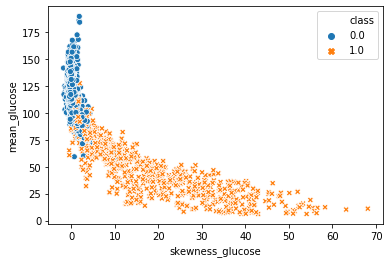

In [51]:
sns.scatterplot(x="skewness_glucose", y="mean_glucose",hue="class", style="class", data=data_frame)

Pri tomto grafe je vidiet, ze cukrovku maju vecsinou ludia, ktori maju zvysenu hladinu skewness glukozi a znizenu hladinu mean glukozi. Z grafu to vyzera tak, ze medzi timito atributmi je nejaka zavislost. Vyzera to na kvadraticku zavislost

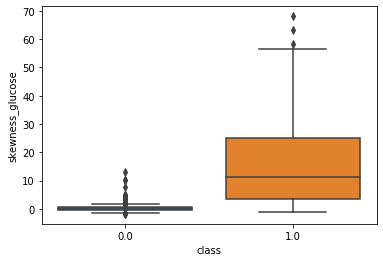

In [52]:
sns.boxplot("class", "skewness_glucose", data=data_frame)

Z grafu je pekne vidiet, vyssie spominana veta, teda ludia trpiaci cukrovkou maju hladinu skewness glukozi vyssiu

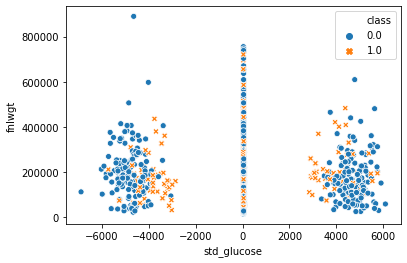

In [54]:
sns.scatterplot(x="std_glucose", y="fnlwgt",hue="class", style="class", data=data_frame)

Po okrajoch je vidiet nejake zhluky,ale nejaku extra velku zavislost tu nevidno no z tohoto grafu sa mi zda, ze vela hodnot bude chybnych, lebo velka cast dat ma hodnotu 0 podme sa na to pozriet kolko hodnot chyba.

In [55]:
data_frame.std_glucose.isnull().sum()

13

Tych hodnot nechyba az tak vela, podme sa na to pozriet cez boxplot

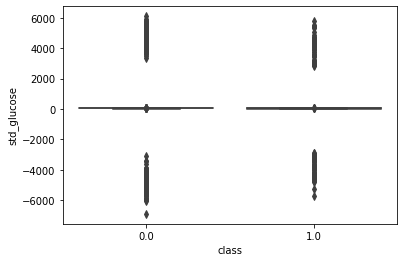

In [59]:
sns.boxplot("class", "std_glucose", data=data_frame)

Tieto grafi sa dost medzi sebou podobaju. Zrejme tu budu aj nejaky outliery, tych planujeme napravit predelenim hodnot nejakou inou hodnotou - pripadne mozno bude treba zmenit znamienko, lebo sa nam nezda ze by std_glucose mohla vynst zaporna

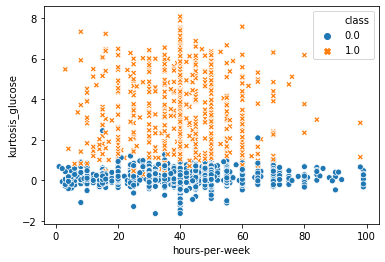

In [60]:
sns.scatterplot(x="hours-per-week", y="kurtosis_glucose",hue="class", style="class", data=data_frame)

Z grafu je pekne vidiet, ze ludia ktory maju cukrovku, maju vecsinou zvysenu hladinu kurtosis glucose, tieto 2 atributy medzi sebou nejaku extra velku zavislost nemaju

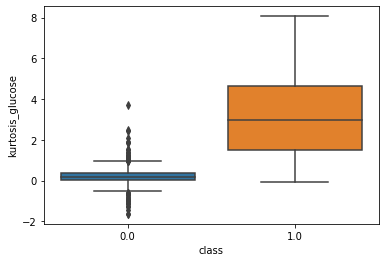

In [61]:
sns.boxplot("class", "kurtosis_glucose", data=data_frame)

Je to pekne vidiet aj z tohoto boxplot grafu

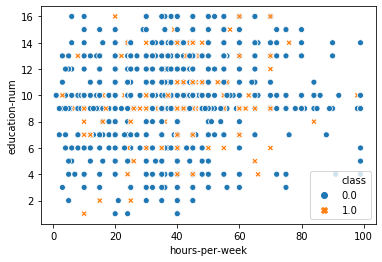

In [63]:
sns.scatterplot(x="hours-per-week", y="education-num",hue="class", style="class", data=data_frame)

Tento graf vizera dost chaoticky, vyzera to tak ze uroven vzdelania vzhladom k hodinam za vykend nevplyva na cukrovku

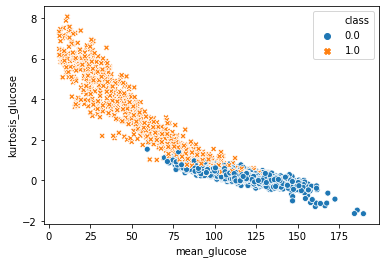

In [88]:
sns.scatterplot(x="mean_glucose", y="kurtosis_glucose",hue="class", style="class", data=data_frame)

Pri tomto grafe je pekne vidiet zavislost tychto 2 atributov. Vyzera ze ide o linearnu zavislost

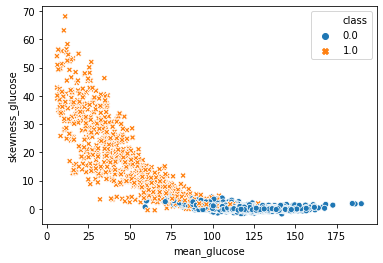

In [89]:
sns.scatterplot(x="mean_glucose", y="skewness_glucose",hue="class", style="class", data=data_frame)

Aj pri tomto grafe je pekne vidiet zavislost tychto 2 atributov. Vyzera to na nejaku kvadraticku funkciu. Ludia majuci cukrovku maju vecsinou hodnotu mean glukozy do 90 a hodnotu skewness glukozy nad 10

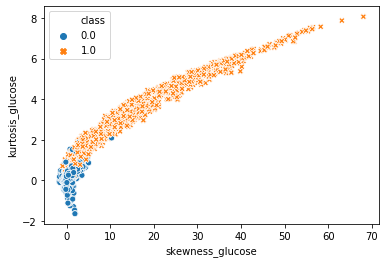

In [90]:
sns.scatterplot(x="skewness_glucose", y="kurtosis_glucose",hue="class", style="class", data=data_frame)

Aj medzi timtio dvoma atributmi je vidiet pekna zavislost. Ludia trpiaci cukrovkou maju vecsinou hladinu kurtosis glukozi nad 2 a hladinu skewness glukozy nad 10

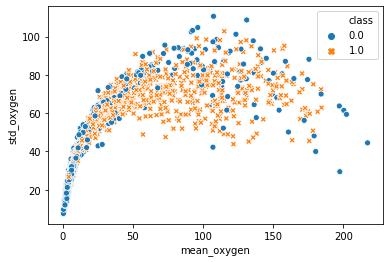

In [91]:
sns.scatterplot(x="mean_oxygen", y="std_oxygen",hue="class", style="class", data=data_frame)

V tomto grafe taktiez vyzera ze by mohla byt nejaka zavislost medzi atributmi. Sice mensia ale vidno tu tvar paraboly, takze nejaka kvadraticka zavislost tu moze byt.

Podme sa na vyssie spominane zavislosti pozriet cez vykreslenu maticu korelacia

In [64]:
corrmat=data_frame.corr()

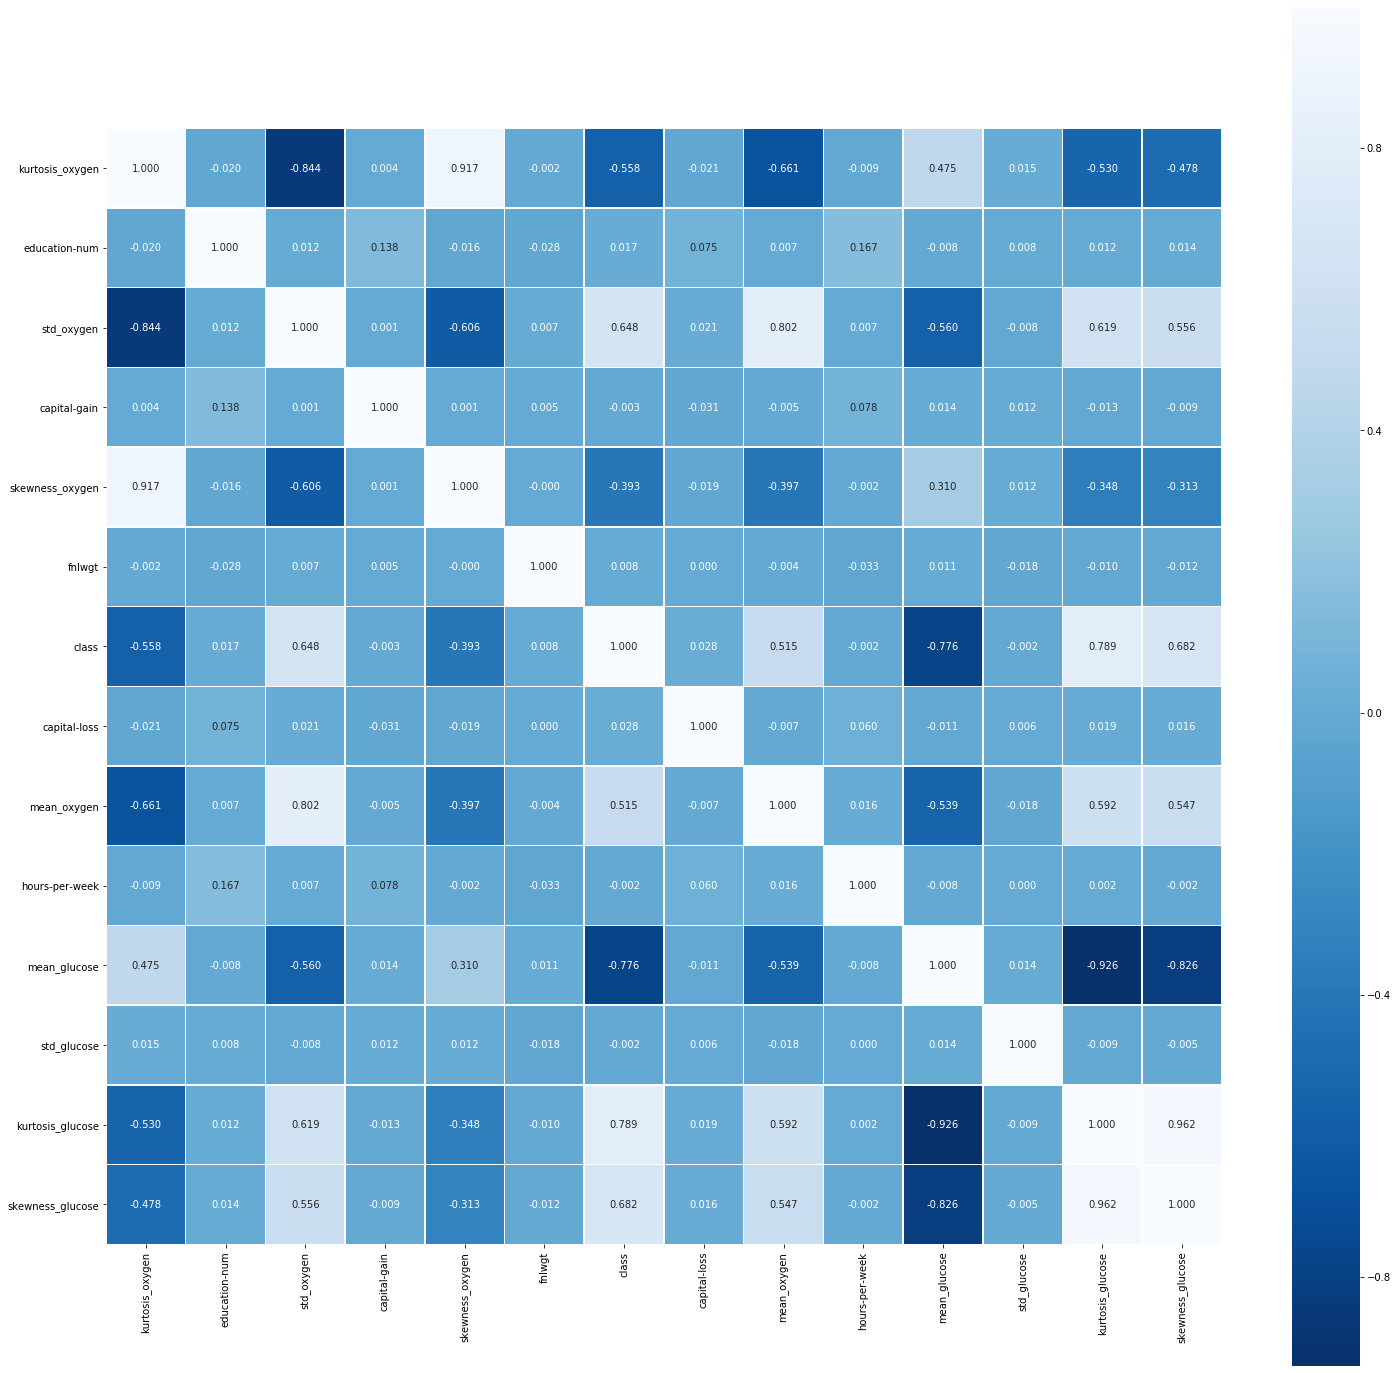

In [67]:
plt.figure(figsize=(25,25))
sns.heatmap(corrmat, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');

Na korelacnej matici, je pekne vidiet korelacie a zavislosti nad jednotlivymi atributmi

Podme sa pozriet ake mame rozlozenie dat pomocou histogramu

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26af4a58>,
      dtype=object)

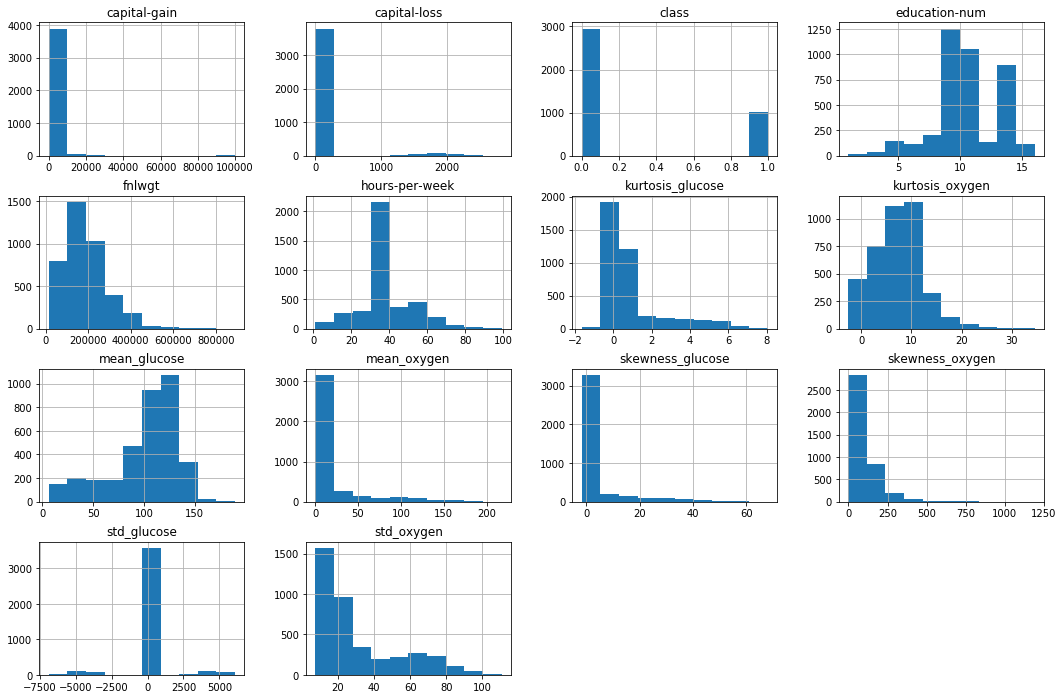

In [92]:
data_frame.hist(figsize=(18,12))

Z grafu je vidiet ze niektore data nemaju normalove rozdelenie. Pri niektorych algoritmoch stojoveho ucenia sa je lepsie, ked mame normalove rozdelenie. Nas navh je v dalsej faze transformovat tieto hodnoty logaritmickou funkciou, alebo pouzit funkciu zo sklearn z-normalization. Zaroven nam to pomoze odstranit nejakych outlierov, ktorych je vidiet na chvostoch jednotlivych histogramov.

Skusme sa pozriet na vizualizaciu atributov, ktore nie su numericke

Najskor sa pozrime na to z akych krajin pacienti pochadzaju a ake je ich zastupenie. Na toto bude asi najlepsi bar chart

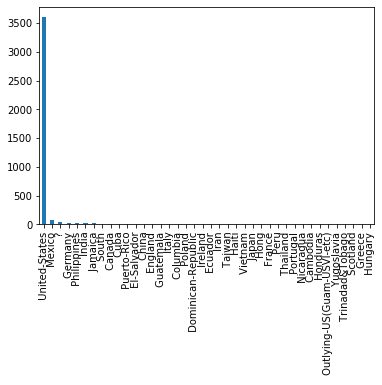

In [68]:
data_frame['native-country'].value_counts().plot(kind='bar')

Z grafu je vidiet, ze pozorovania boli asi robene v united states, nakolko prevaznu cast datasetu tvoria ludia z tejto krajiny

Skusme sa pozrier na rasu

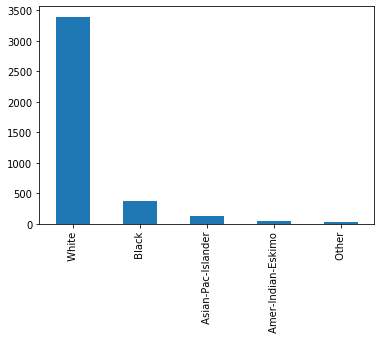

In [71]:
data_frame.race.value_counts().plot(kind='bar')

Z grafu je vidiet, ze najviac pozorovani bolo robenych na belochoch, tento atribut, ako aj atribut vysie by sa mohol pre trenovanie zakodovat pod nejake cislo aby sa to algoritmus vedel naucit. Jedna sa o nominalne atributy

Skusme sa pozriet v akom sektore pracuju

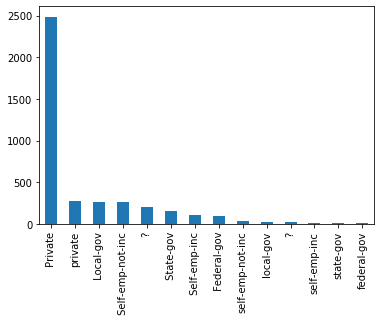

In [72]:
data_frame.workclass.value_counts().plot(kind='bar')

Z grafu je vidiet ze v niektorych nazvoch su preklepi. V dalsej faze tieto preklepi odstranime tak, ze Private nechame s velkym P a nekorektne data opravime. Otaznik by sa mohol doplnit pomocou algoritmu k-means, teda by sme sa pozreli na data ktore maju podobne hodnoty a doplnili to z nich.

Skusme sa pozriet na ich vztahy

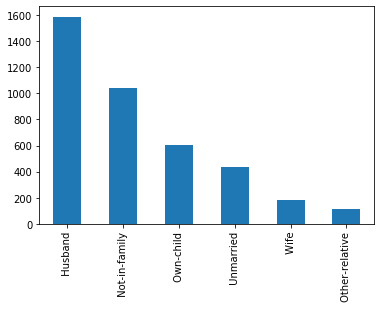

In [73]:
data_frame.relationship.value_counts().plot(kind='bar')

Teraz sa pozrime na ich uroven vzdelania

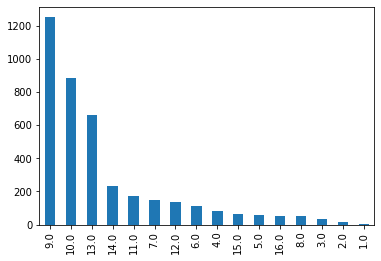

In [75]:
data_frame['education-num'].value_counts().plot(kind='bar')

Z grafu je vidiet ze su tu rozne hodnoty vzdelania, najviac ludi je vsak s hodnotou 9

Pozrime sa kolko mame tehotnych zien

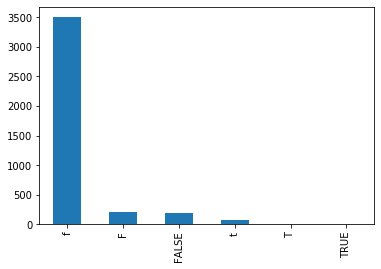

In [76]:
data_frame.pregnant.value_counts().plot(kind='bar')

Z grafu je vidiet ze mame viacero nazvov. V dalsej faze nastavime iba 2 - f,t. Ostatne nekorektne data premenujeme

Pozrime sa na inkom, vsimol som si ze tam mame iba 2 hodnoty, skusme si to overit

In [77]:
data_frame.income.unique()

array([' <=50K', ' >50K', nan], dtype=object)

Hodnoty su iba 2. Pozrime sa teda na pomer pomocou pie chartu

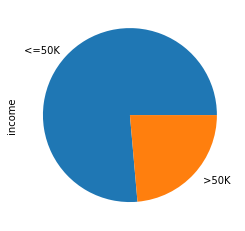

In [78]:
data_frame.income.value_counts().plot(kind='pie')

Z grafu je vidiet ze viac ludi ma hodnotu mensiu ako 50k

# Analyza druhej vzorky datasetu

In [5]:
personal_data_train.head()

,Unnamed: 0,name,address,age,sex,date_of_birth
0,0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",48,Female,1971-05-28
1,1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",69,Male,1950-02-27 00:00:00
2,2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",45,Female,1974-01-18
3,3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",NaN,Male,1955-06-09
4,4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",23,Male,1995-11-03


Tento dataset ma onieco menej stlpcov ako dataset vyssie. Podobne ako v datasete vyssie aj tento ma stlpec unnamed0, ktory zmenim na index. Potom nasleduje meno, adresa ktora je v takom formate ze by pasovala este sparcovat(napr cez delimiter \r\n). Potom nasleduje vek, pohlavie a datum narodenia. Skusme sa pozriet na deskriptivne statistiky tohoto datasetu

In [79]:
personal_data_train.describe()

,Unnamed: 0
count,3933.000000
mean,1966.000000
std,1135.503633
min,0.000000
25%,983.000000
50%,1966.000000
75%,2949.000000
max,3932.000000


Aha, vidime ze nam to urobilo descriptivnu statistiku iba pre stlpec unnamed, podme ho zmenit na index. Urobime to podobne ako s datasetom vyssie. Stlpec premenujeme na index a nastavime ho ako index.

In [80]:
personal_data_train = personal_data_train.rename(columns={'Unnamed: 0': 'index',})
personal_data_train = personal_data_train.set_index('index')
personal_data_train.head()

,name,address,age,sex,date_of_birth
index,,,,,
0,Roscoe Bohannon,"7183 Osborne Ways Apt. 651\r\nEast Andrew, OH ...",48,Female,1971-05-28
1,Ernest Kline,"391 Ball Road Suite 961\r\nFlowersborough, IN ...",69,Male,1950-02-27 00:00:00
2,Harold Hendriks,"8702 Vincent Square\r\nNew Jerryfurt, CO 30614",45,Female,1974-01-18
3,Randy Baptiste,"2751 Harris Crossroad\r\nWest Ashley, CA 30311",NaN,Male,1955-06-09
4,Anthony Colucci,"904 Robert Cliffs Suite 186\r\nWest Kyle, CO 7...",23,Male,1995-11-03


Hned to vyzera lepsie, pozrime sa na dalsie informacie o datach

In [81]:
personal_data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3933 entries, 0 to 3932
Data columns (total 5 columns):
name             3933 non-null object
address          3933 non-null object
age              3671 non-null object
sex              3933 non-null object
date_of_birth    3933 non-null object
dtypes: object(5)
memory usage: 184.4+ KB


Vek je brany ako object, v dalsej faze ho bude treba pretipovat na int. Taktiez date_of_birth bude treba zmenit na tip date. Pozrime sa kolko mame riadkov a stlpcov v datasete

In [83]:
personal_data_train.shape[0]

3933

In [84]:
personal_data_train.shape[1]

5

Prva vec co ma zaujala je pocet riadkov, nakolko v tomto datasete sa mi zda ze je menej riadkov ako v datasete hore, podme to zistit

In [85]:
data_frame.shape[0] - personal_data_train.shape[0]

50

Nase podozrenie sa potvrdilo, mame o 50 riadkov menej. Pozrime sa ci tu mame nejake duplicity podla mena

In [86]:
personal_data_train[personal_data_train.name.isin(personal_data_train.name[personal_data_train.name.duplicated()])].sort_values(by=['name'])

,name,address,age,sex,date_of_birth
index,,,,,


V tomto datasete vyzera ze asi nebudu ziadne duplicitne zaznami

Pozrime sa kolko hodnot mame nan

In [88]:
personal_data_train.isnull().sum()

name               0
address            0
age              262
sex                0
date_of_birth      0
dtype: int64

Takze nan mame iba pri veku. Vek by sa dal dopocitat z datumu narodenia.

Kedze v tichto datach nemame vela numerickych hodnot, neda sa pozorovat ani korelacie, zavislosti medzi atributami,  alebo parova analyza. Mozme sa ale pozret napr. na pomer pohlavia v datasete pomocou pie chartu

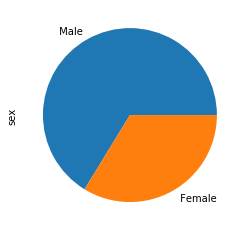

In [89]:
personal_data_train.sex.value_counts().plot(kind='pie')

Vidime ze pozorovania sa robili na viacerych muzoch nez zenach. Skusme sa pozriet ake mame vsetky druhy datumov v datasete

In [139]:
date_formats = personal_data_train.date_of_birth
date_formats = date_formats.astype(str)
date_formats.head()

index
0             1971-05-28
1    1950-02-27 00:00:00
2             1974-01-18
3             1955-06-09
4             1995-11-03
Name: date_of_birth, dtype: object

In [140]:
date_formats = date_formats.str.replace('\d', '0')
date_formats.head()

index
0             0000-00-00
1    0000-00-00 00:00:00
2             0000-00-00
3             0000-00-00
4             0000-00-00
Name: date_of_birth, dtype: object

In [141]:
date_formats.unique()

array(['0000-00-00', '0000-00-00 00:00:00', '00/00/0000',
       '0000-00-00 00 00 00', '00-00-00', '0000/00/00'], dtype=object)

Toto su vsetky typi datumov, kedze ich je vela moze nastat problem, ze niektore roky to vypocita zle. Najlepsie to bude asi osetrit regexom

Skusme sa pozriet ake vsetky formaty mame roky 

In [144]:
years = personal_data_train.age
years.head()

index
0     48
1     69
2     45
3    NaN
4     23
Name: age, dtype: object

In [146]:
years = years.str.replace('\d', '0')
years.head()

index
0     00
1     00
2     00
3    NaN
4     00
Name: age, dtype: object

In [147]:
years.unique()

array(['00', nan, '??', '000', '-0', '0'], dtype=object)

Takze vidime ze tu mame nejake zaporne roky, otazniky, a nejakych ludi s vekom asi nad 100, co budu pravdepodobne outlyeri

Ako som sa dostal k vsetkym formatom ktore su v danom stlpci? najprv som zmenil vsetky cisla na 0, a potom som nad tim zavolal unique aby mi dalo jedinecne hodnoty

In [149]:
transformed_dates = []

for date in personal_data_train.date_of_birth:
    date = re.sub(r'[\-\:\/]', '-', date)
    date = date.split()[0]
    date = parser.parse(date)
    if date.year > 2019:
        transformed_dates.append('19' + date.isoformat().split('T')[0][2:])
    else:
        transformed_dates.append(date.isoformat().split('T')[0])

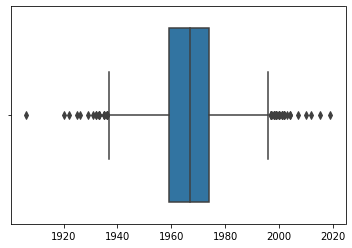

In [156]:
sns.boxplot(pd.to_datetime(transformed_dates).year)

In [159]:
transformed_dates = pd.to_datetime(transformed_dates)

In [160]:
transformed_dates[transformed_dates.year>2018]

DatetimeIndex(['2019-05-05'], dtype='datetime64[ns]', freq=None)

In [164]:
personal_data_train[personal_data_train.age == '14']

,name,address,age,sex,date_of_birth
index,,,,,
782,Michael Bartholomew,"94968 Krystal Mount\r\nWest Carmenland, UT 21553",14,Female,05-05-19
3308,Randy Mckee,86866 Vanessa Coves Suite 768\r\nMichelleville...,14,Female,2004-11-02


In [166]:
transformed_dates[782]

Timestamp('2019-05-05 00:00:00')

# Hypotezi a ich testovanie

### Hypoteza c.1: Ludia ktory maju zvysenu hladinu kurtosis glucose castejsie trpia chorobou stitnej zlazy

Podme si znova zobrazit boxplot pre kurtosis glucose

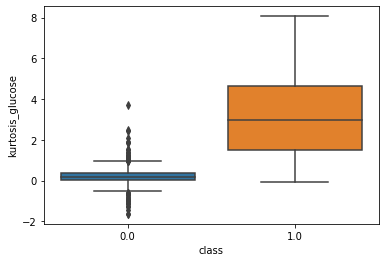

In [36]:
sns.boxplot("class", "kurtosis_glucose", data=data_frame)

In [39]:
true_kurtosis = data_frame.loc[data_frame['class']==1, 'kurtosis_glucose']
false_kurtosis = data_frame.loc[data_frame['class']==0, 'kurtosis_glucose']

In [40]:
true_kurtosis.describe()

count    1018.000000
mean        3.123128
std         1.882943
min        -0.094888
25%         1.519625
50%         2.969088
75%         4.646931
max         8.069522
Name: kurtosis_glucose, dtype: float64

In [41]:
false_kurtosis.describe()

count    2939.000000
mean        0.207601
std         0.320912
min        -1.641515
25%         0.009648
50%         0.184205
75%         0.390190
max         3.691603
Name: kurtosis_glucose, dtype: float64

In [42]:
true_kurtosis = true_kurtosis.dropna()
false_kurtosis = false_kurtosis.dropna()

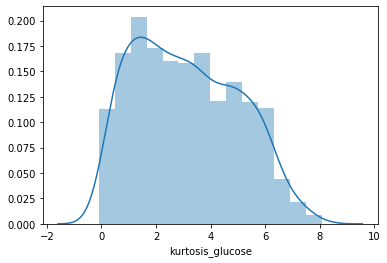

In [45]:
sns.distplot(true_kurtosis)

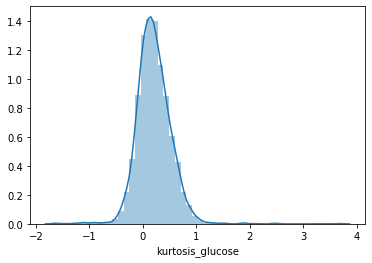

In [46]:
sns.distplot(false_kurtosis)

In [52]:
def get_outliers(dataset):
    bottom = dataset.quantile(0.25) - 1.5 * stats.iqr(dataset)
    top = dataset.quantile(0.75) + 1.5 * stats.iqr(dataset)
    return dataset[(dataset >= top) | (dataset <= bottom)]

In [54]:
outliers = get_outliers(false_kurtosis)
false_kurtosis = false_kurtosis.drop(outliers.index)
outliers = get_outliers(true_kurtosis)
true_kurtosis = true_kurtosis.drop(outliers.index)

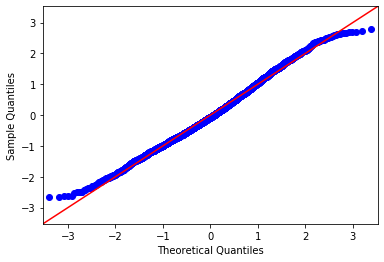

In [60]:
_ = sm.ProbPlot(false_kurtosis, fit=True).qqplot(line='45')

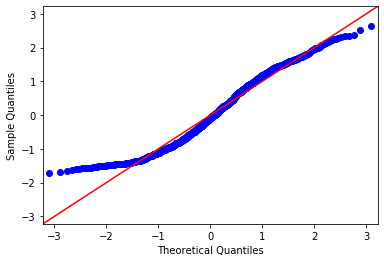

In [61]:
_ = sm.ProbPlot(true_kurtosis, fit=True).qqplot(line='45')

alfa(hranicna p hodnota) hodnotu sme si dali 0,05 podla prednasky

In [62]:
stats.shapiro(true_kurtosis)

(0.9631593823432922, 2.3273430895014635e-15)

In [63]:
stats.shapiro(false_kurtosis)

(0.994434118270874, 5.379651391024254e-09)

Obe datove sady pochazdaju z ineho nez normalneho rozdelenia, lebo p < 0,05

In [64]:
stats.levene(true_kurtosis,false_kurtosis)

LeveneResult(statistic=5143.3950167859075, pvalue=0.0)

Na zaklade dat mozeme prehlasit ze vzorky pochadzaju z distribucii s roznymi varianciami, pretoze p = 0  
Na zaklade tychto vysledkov je vhodne pouzit mann whiteneyho u-test

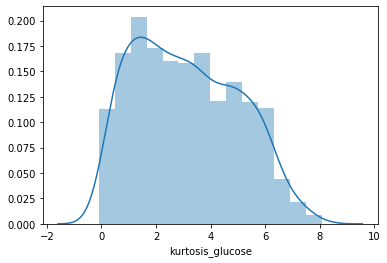

In [65]:
sns.distplot(true_kurtosis)

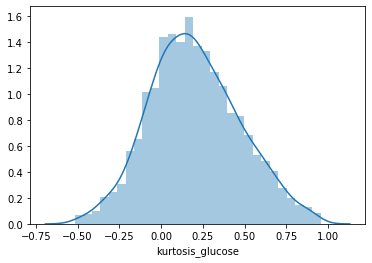

In [66]:
sns.distplot(false_kurtosis)

alfa hodnotu sme si dali 0,001 podla prednasky

In [67]:
stats.mannwhitneyu(true_kurtosis,false_kurtosis)

MannwhitneyuResult(statistic=74655.0, pvalue=0.0)

Na zaklade mann whitneyho u-testu sme dokazali ze pravdepodobnost chyby prveho radu je menej ako 1 promile (p = 0)  
Mozme prehlasit ze rozdiel v hodnotach kurtosis glucose vzhladom na vyskyt choroby stitnej zlazy je statisticky signifikantny, takze hypoteza 1 plati

### Hypoteza c.2: ludia trpiaci chorobou stitnej zlazi maju zvysenu hodnotu skewness glucose

Znova si najskor vykreslime boxplot

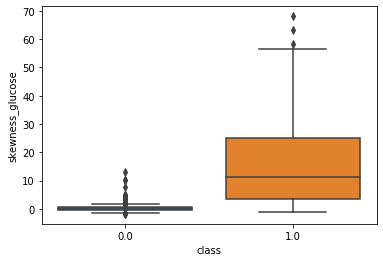

In [68]:
sns.boxplot("class", "skewness_glucose", data=data_frame)

In [69]:
true_skewness = data_frame.loc[data_frame['class']==1, 'skewness_glucose']
false_skewness = data_frame.loc[data_frame['class']==0, 'skewness_glucose']

In [70]:
true_skewness.describe()

count    1018.000000
mean       15.508308
std        13.932852
min        -1.139069
25%         3.660513
50%        11.379835
75%        25.239094
max        68.101622
Name: skewness_glucose, dtype: float64

In [71]:
false_skewness.describe()

count    2939.000000
mean        0.356168
std         0.943607
min        -1.755332
25%        -0.220464
50%         0.129231
75%         0.621971
max        13.158998
Name: skewness_glucose, dtype: float64

In [73]:
true_skewness = true_skewness.dropna()
false_skewness = false_skewness.dropna()

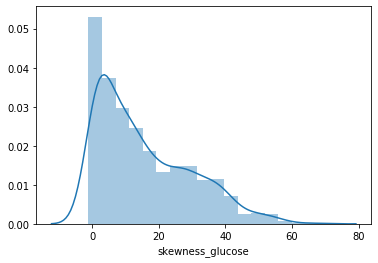

In [74]:
sns.distplot(true_skewness)

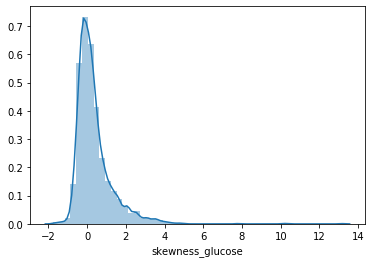

In [75]:
sns.distplot(false_skewness)

In [76]:
outliers = get_outliers(false_skewness)
false_skewness = false_skewness.drop(outliers.index)
outliers = get_outliers(true_skewness)
true_skewness = true_skewness.drop(outliers.index)

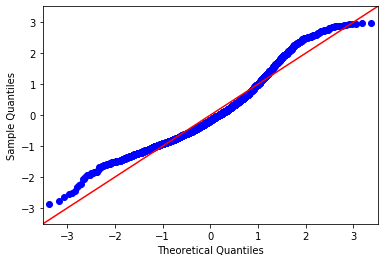

In [78]:
_ = sm.ProbPlot(false_skewness, fit=True).qqplot(line='45')

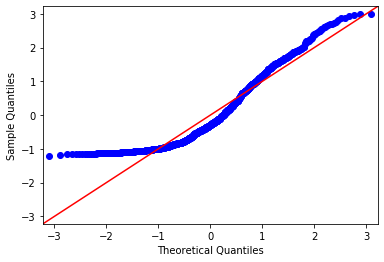

In [77]:
_ = sm.ProbPlot(true_skewness, fit=True).qqplot(line='45')

p hodnotu sme si dali 0,05 podla prednasky

In [79]:
stats.shapiro(true_skewness)

(0.9024069309234619, 6.407079461436547e-25)

In [80]:
stats.shapiro(false_skewness)

(0.955822765827179, 4.943152943540014e-28)

Obe datove sady pochazdaju z ineho nez normalneho rozdelenia, lebo p < 0,05

In [81]:
stats.levene(true_skewness,false_skewness)

LeveneResult(statistic=3711.1641771682444, pvalue=0.0)

Na zaklade dat mozeme prehlasit ze vzorky pochadzaju z distribucii s roznymi varianciami, pretoze p = 0  
Na zaklade tychto vysledkov je vhodne pouzit mann whiteneyho u-test

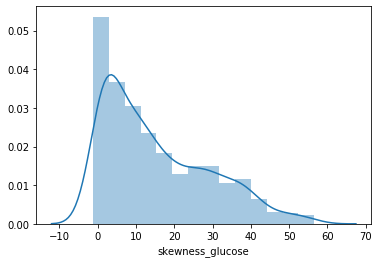

In [82]:
sns.distplot(true_skewness)

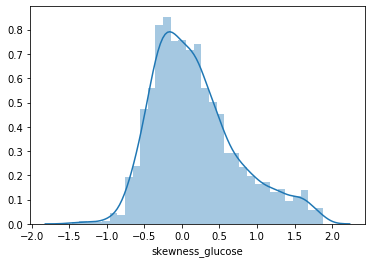

In [83]:
sns.distplot(false_skewness)

alfa hodnotu sme si dali 0,001 podla prednasky

In [84]:
stats.mannwhitneyu(true_skewness,false_skewness)

MannwhitneyuResult(statistic=123246.0, pvalue=0.0)

Na zaklade mann whitneyho u-testu sme dokazali ze pravdepodobnost chyby prveho radu je menej ako 1 promile (p = 0)  
Mozme prehlasit ze rozdiel v hodnotach skewness glucose vzhladom na vyskyt choroby stitnej zlazy je statisticky signifikantny, takze hypoteza 1 plati

V nasledujucej faze planujeme spojit datasety pomocou mena a adresy, nakolko viacero ludi moze mat rovnake meno.  
Planujeme to spojit pomocou sql prikazu (join) v pythone.

## Zhrnutie 
V projekte sme opisali jednotlive data, ako aj atributy kazdeho datasetu. Taktiez sme k nim vypisali deskriptivnu statistiku. Pre niektore sme znazornili distibuciu. Popisali sme ze typ niektorych atributov bude treba zmenit napr. vek. Pri veku chybali nejake hodnoty, ktore planujeme dopocitat pomocou roku narodenia. Nasledne sme vykonali parovu analyzu, kde sme opisali jednotlive vizualizacie grafov, zavislosti a nejake zaujimavosti, ktore sme z dat vycitali. Potom sme pomocou grafou navrhli 2 hypotezi, ktore sme nasledne overili a potvrdili.  
         Taktiez sme identifikovali problemy v datach, ako su chybajuce hodnoty, ktore planujeme doplnit bud medianom, priemerom alebo natrenujeme nejaky algoritmus na predikciu danych hodnot(napr. k-means). Duplicitne zaznami planujeme nahradit iba 1 zaznamom. Vsimli sme si ze v niektorych riadkoch su pri duplicitach chybajuce udaje, takze tieto udaje sa pokusime nahradit druhym zaznamom danej osoby. Nasledne sme nasli aj nejednotne formaty dat - napr. datum narodenia, ktori planujeme v dalsej faze opravit pomocou regexu, kde budeme zaroven porovnavat s aktualnym vekom. Dalsie nejednotne formaty su napr. vek, kde sa nachadzaju ?, zaporne hodnoty a rozne vychylene hodnoty. Ako bolo vyssie spominane, planujeme ich opravit pomocou roku narodenia. Narazili sme aj na nevhodnu strukturu dat, v stlpci medical_info. Tuto nevhodnu strukturu dat sme uz opravili a hodnoty sme rozdelili do viacerych stlpcov.  
         Taktiez sme aj identifikovaly outlierov - vychylene hodnoty. Tie planujeme napravit bud skumanim (mozu sa riesit nejakou konstantou oproti inym datam - zla premena jednotiek a pod) a naslednim predelenim, alebo nahradenim medianom, priemerom, normalizaciu pomocou logaritmu, alebo z-normalizaciou, pripadne natrenovanim nejakeho algoritmu strojoveho ucenia a naslednou predikciou tohoto algoritmu pre dany atribut. 